<a href="https://colab.research.google.com/github/escapingLife/mashinePrograming/blob/master/9%EC%A3%BC%EC%B0%A8/Alcohol_Sales_window_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ------------------------------------
# 1. 데이터 로드
# ------------------------------------
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Alcohol_Sales.csv')
data = df['S4248SM144NCEN'].values.reshape(-1, 1)

In [35]:
# ------------------------------------
# 2. 정규화
# ------------------------------------
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [36]:
# ------------------------------------
# 3. 시퀀스 생성 (window=6)
# ------------------------------------
window = 6
X, y = [], []
for i in range(len(data) - window):
    X.append(data[i:i+window])
    y.append(data[i+window])
X, y = np.array(X), np.array(y)

In [37]:
# ------------------------------------
# 4. Train/Test 분할 (8:2, 시계열이므로 shuffle X)
# ------------------------------------
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [38]:
# ------------------------------------
# 5. 첫 번째 모델 (RNN)
# ------------------------------------
model_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, activation='tanh', input_shape=(window, 1)),
    tf.keras.layers.Dense(1)
])
model_rnn.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
# ------------------------------------
# 6. 두 번째 모델 (LSTM)
# ------------------------------------
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True, input_shape=(window, 1)),
    tf.keras.layers.LSTM(32, activation='tanh'),
    tf.keras.layers.Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

In [40]:
# ------------------------------------
# 7. 모델 학습
# ------------------------------------
history_rnn = model_rnn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=8,
    verbose=1
)

history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=8,
    verbose=1
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0194 - val_loss: 0.0240
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - val_loss: 0.0187
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - val_loss: 0.0139
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047 - val_loss: 0.0136
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - val_loss: 0.0134
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - val_loss: 0.0132
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - val_loss: 0.0135
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - val_loss: 0.0153
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056 - val_loss: 0.0132
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - val_loss: 0.0147
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - val_loss: 0.0131
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0057 - val_l

In [41]:
# ------------------------------------
# 8. 테스트 데이터로 예측 (훈련 데이터 사용 X)
# ------------------------------------
pred_rnn = model_rnn.predict(X_test)
pred_lstm = model_lstm.predict(X_test)

# 앙상블: 평균
final_pred = (pred_rnn + pred_lstm) / 2

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 


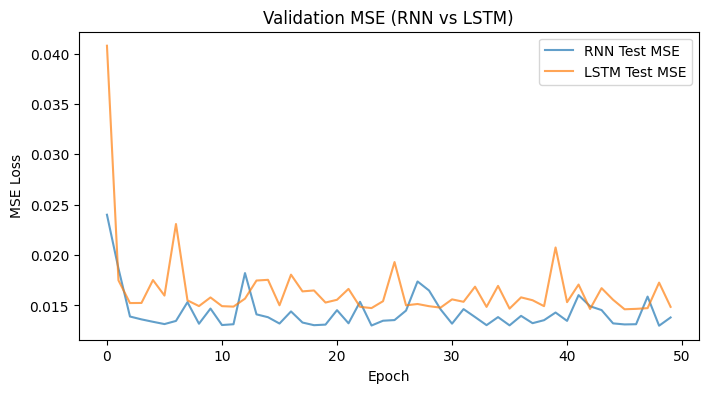

In [42]:
# ------------------------------------
# 9. MSE 시각화
# ------------------------------------
plt.figure(figsize=(8,4))
plt.plot(history_rnn.history['val_loss'], label='RNN Test MSE', alpha=0.7)
plt.plot(history_lstm.history['val_loss'], label='LSTM Test MSE', alpha=0.7)
plt.title('Validation MSE (RNN vs LSTM)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

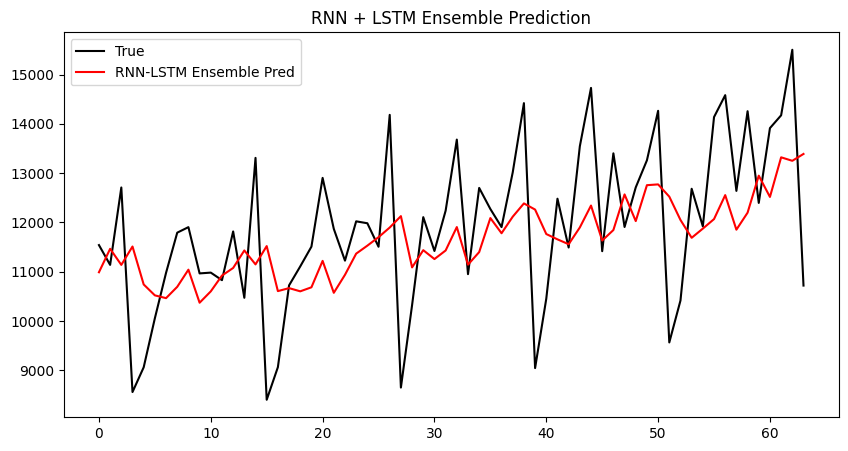

In [43]:
# ------------------------------------
# 10. 실제값 vs 예측값 시각화
# ------------------------------------
true_vals = scaler.inverse_transform(y_test)
pred_avg = scaler.inverse_transform(final_pred)

plt.figure(figsize=(10,5))
plt.plot(true_vals, label='True', color='black')
plt.plot(pred_avg, label='RNN-LSTM Ensemble Pred', color='red')
plt.title('RNN + LSTM Ensemble Prediction')
plt.legend()
plt.show()